3rd Gaussian Momento Skewness for lc 6: -1.60
4th Gaussian Moment Kurtosis for lc 6: 5.11
3rd Gaussian Momento Skewness for lc 8: -0.98
4th Gaussian Moment Kurtosis for lc 8: 3.61
3rd Gaussian Momento Skewness for lc 10: -0.60
4th Gaussian Moment Kurtosis for lc 10: 2.71
3rd Gaussian Momento Skewness for lc 12: -0.26
4th Gaussian Moment Kurtosis for lc 12: 2.90


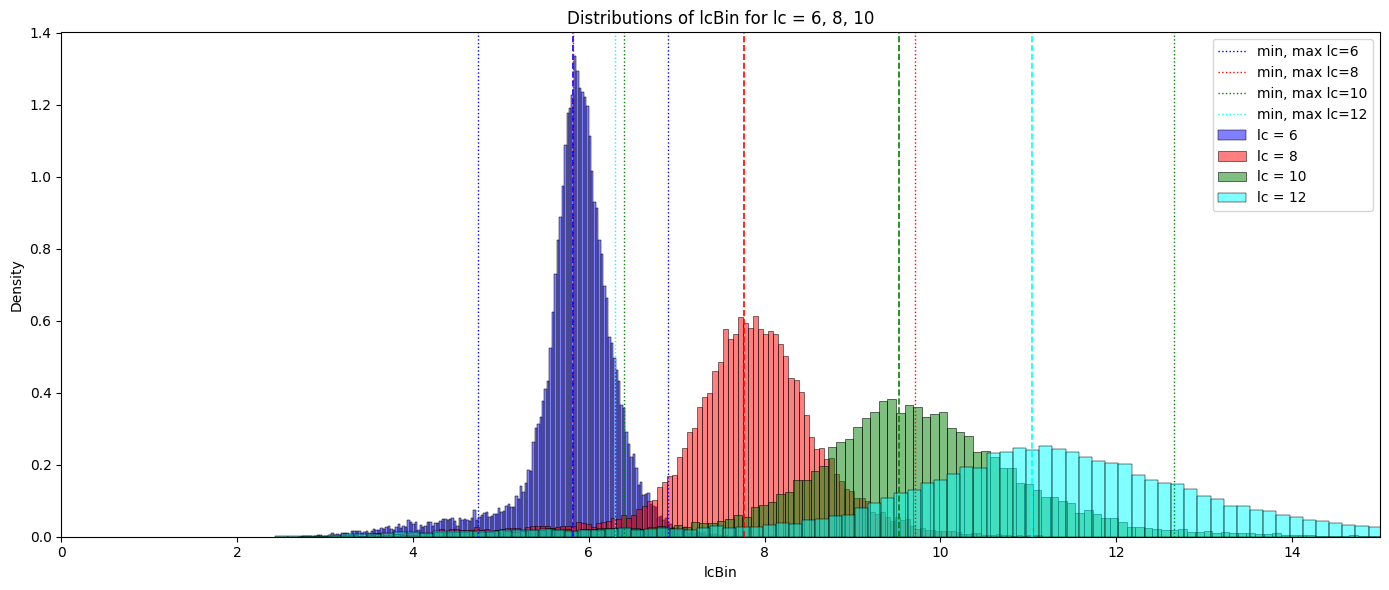

In [25]:
### Exploratory Data Analysis ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

bins='auto'
data = pd.read_csv('csv back/ind_output_3D_v4_filtered.csv')

def calculate_stats(data, lc_value, column='lcBin'):
    subset = data[data['lc'] == lc_value]
    mean = subset[column].mean()
    std = subset[column].std()
    minlim = mean - 2*std
    maxlim = mean + 2*std
    skewness = skew(subset[column])
    kurt = kurtosis(subset[column])
    return subset, mean, std, minlim, maxlim, skewness, kurt

lc_values = [6,8,10,12]

stats = {}
for lc in lc_values:
    stats[lc] = calculate_stats(data, lc)

# Filter data by connectivity structure
data_ics = data[data['con'] == 1]
data_hcs = data[data['con'] == 2]
data_lcs = data[data['con'] == 3]

plt.figure(figsize=(14, 6))
colors = ['blue', 'red', 'green', 'cyan']
for i, lc in enumerate(lc_values):
    subset, mean, std, minlim, maxlim, skewness, kurt = stats[lc]
    sns.histplot(subset['lcBin'], bins=bins, kde=False, color=colors[i], alpha=0.5, label=f'lc = {lc}', stat="density")
    plt.axvline(x=mean, color=colors[i], linewidth=1.2, linestyle='--')  
    plt.axvline(x=minlim, color=colors[i], linewidth=1, linestyle=':', label=f'min, max lc={lc}')
    plt.axvline(x=maxlim, color=colors[i], linewidth=1, linestyle=':')
    print(f'3rd Gaussian Momento Skewness for lc {lc}: {skewness:.2f}')
    print(f'4th Gaussian Moment Kurtosis for lc {lc}: {kurt:.2f}')

plt.legend()
plt.xlabel('lcBin')
#plt.ylabel('Relative frequency')
plt.title(f'Distributions of lcBin for lc = {lc_values[0]}, {lc_values[1]}, {lc_values[2]}')#, {lc_values[3]}')
plt.xlim(0, 15) 
plt.tight_layout()
plt.show()


Statistics for lc = 6 (filtered):
Mean: 5.87
Std Dev: 0.43
Skewness: -0.69
Kurtosis: 2.28
Number of original samples: 29232
Number of filtered samples: 30804
Samples removed: 808 (2.6%)

Statistics for lc = 8 (filtered):
Mean: 7.83
Std Dev: 0.82
Skewness: -0.41
Kurtosis: 1.54
Number of original samples: 29232
Number of filtered samples: 30534
Samples removed: 712 (2.3%)

Statistics for lc = 10 (filtered):
Mean: 9.59
Std Dev: 1.38
Skewness: -0.38
Kurtosis: 1.38
Number of original samples: 29232
Number of filtered samples: 29573
Samples removed: 586 (2.0%)

Statistics for lc = 12 (filtered):
Mean: 11.06
Std Dev: 2.17
Skewness: -0.51
Kurtosis: 1.23
Number of original samples: 29232
Number of filtered samples: 28822
Samples removed: 410 (1.4%)


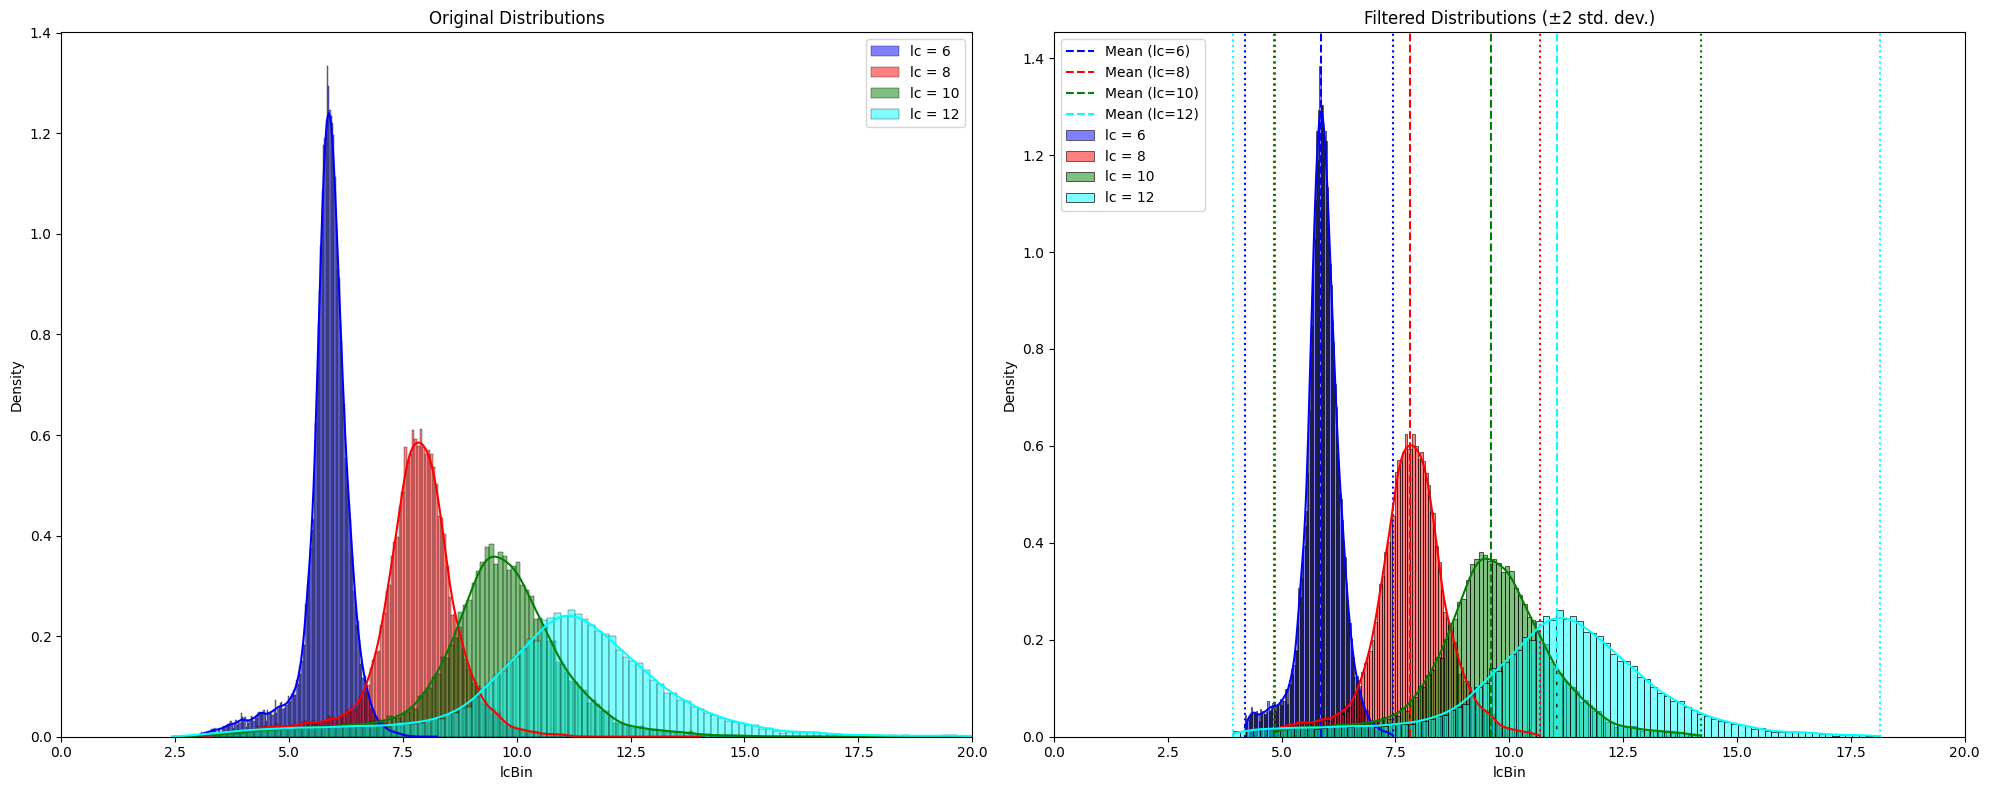

In [26]:
### Exploratory Data Analysis ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

def calculate_stats_and_filter(data, lc_value, column='lcBin'):
    """Calculate statistics and filter data within ±2 standard deviations"""
    subset = data[data['lc'] == lc_value]
    mean = subset[column].mean()
    std = subset[column].std()
    std_filter = 3
    minlim = mean - std_filter*std
    maxlim = mean + std_filter*std
    
    # Filter data
    filtered_subset = subset[(subset[column] >= minlim) & 
                           (subset[column] <= maxlim)]
    
    # Calculate statistics for filtered data
    filtered_mean = filtered_subset[column].mean()
    filtered_std = filtered_subset[column].std()
    skewness = skew(filtered_subset[column])
    kurt = kurtosis(filtered_subset[column])
    
    stats = {
        'mean': filtered_mean,
        'std': filtered_std,
        'minlim': minlim,
        'maxlim': maxlim,
        'skewness': skewness,
        'kurtosis': kurt,
        'n_samples': len(filtered_subset),
        'removed_samples': len(subset) - len(filtered_subset)
    }
    
    return filtered_subset, stats

def plot_distributions(original_data, filtered_data, stats, colors, lc_values, bins):
    """Create side-by-side plots of original and filtered distributions"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot original distributions
    for i, lc in enumerate(lc_values):
        subset = original_data[original_data['lc'] == lc]
        sns.histplot(data=subset, x='lcBin', bins=bins, kde=True,
                    alpha=0.5, label=f'lc = {lc}', color=colors[i],
                    stat="density", ax=ax1)  
    
    ax1.set_title('Original Distributions')
    ax1.set_xlabel('lcBin')
    ax1.set_ylabel('Density')
    ax1.set_xlim(0, 20)
    ax1.legend()
    
    # Plot filtered distributions
    for i, lc in enumerate(lc_values):
        filtered_subset = filtered_data[lc][0]
        stat = filtered_data[lc][1]
        
        sns.histplot(data=filtered_subset, x='lcBin', bins=bins, kde=True,
                    color=colors[i], alpha=0.5, label=f'lc = {lc}',
                    stat="density", ax=ax2)
        
        # Add mean and limit lines
        ax2.axvline(x=stat['mean'], color=colors[i], linestyle='--',
                   label=f'Mean (lc={lc})')
        ax2.axvline(x=stat['minlim'], color=colors[i], linestyle=':')
        ax2.axvline(x=stat['maxlim'], color=colors[i], linestyle=':')
        
        print(f"\nStatistics for lc = {lc} (filtered):")
        print(f"Mean: {stat['mean']:.2f}")
        print(f"Std Dev: {stat['std']:.2f}")
        print(f"Skewness: {stat['skewness']:.2f}")
        print(f"Kurtosis: {stat['kurtosis']:.2f}")
        print(f'Number of original samples: {len(subset)}')
        print(f'Number of filtered samples: {len(filtered_subset)}')
        print(f"Samples removed: {stat['removed_samples']} ({stat['removed_samples']/stat['n_samples']*100:.1f}%)")
    
    ax2.set_title('Filtered Distributions (±2 std. dev.)')
    ax2.set_xlabel('lcBin')
    ax2.set_ylabel('Density')
    ax2.set_xlim(0, 20)
    ax2.legend()
    
    plt.tight_layout()
    return fig, (ax1, ax2)

# Main execution
bins = 'auto'
data = pd.read_csv('csv back/ind_output_3D_v4_filtered.csv')
lc_values = [6, 8, 10, 12]
#colors = ['blue', 'red', 'green']

# Calculate statistics and filter data
filtered_data = {}
for lc in lc_values:
    filtered_subset, stats = calculate_stats_and_filter(data, lc)
    filtered_data[lc] = (filtered_subset, stats)

# Create plots
fig, axes = plot_distributions(data, filtered_data, stats, colors, lc_values, bins)
plt.show()


Statistics for lc = 6:
mean: 1.926
std: 1.033
skewness: -0.594
kurtosis: -0.526
n_samples: 30175.000

Statistics for lc = 8:
mean: 1.973
std: 1.037
skewness: -0.628
kurtosis: -0.510
n_samples: 29841.000

Statistics for lc = 10:
mean: 2.025
std: 1.012
skewness: -0.626
kurtosis: -0.482
n_samples: 28871.000

Statistics for lc = 12:
mean: 2.060
std: 0.986
skewness: -0.654
kurtosis: -0.384
n_samples: 27954.000


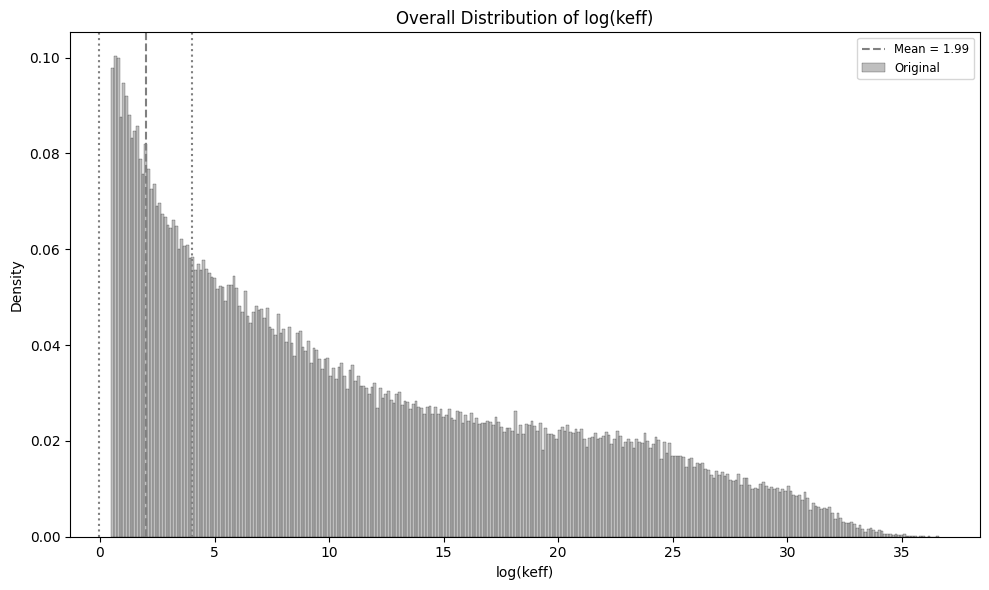

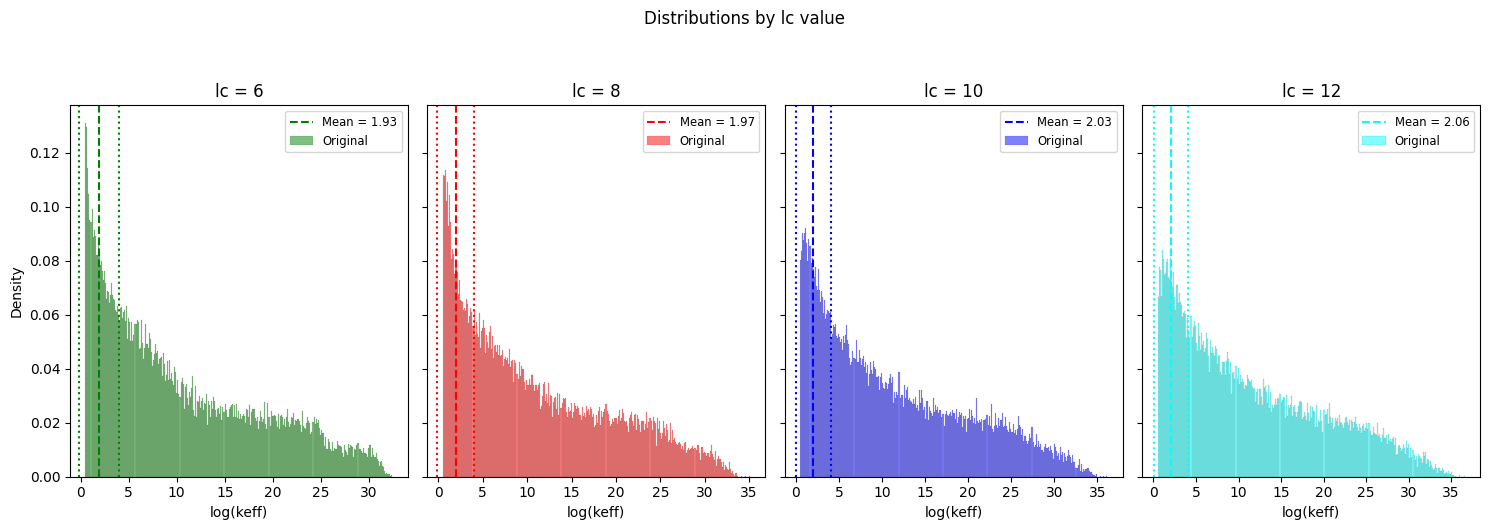

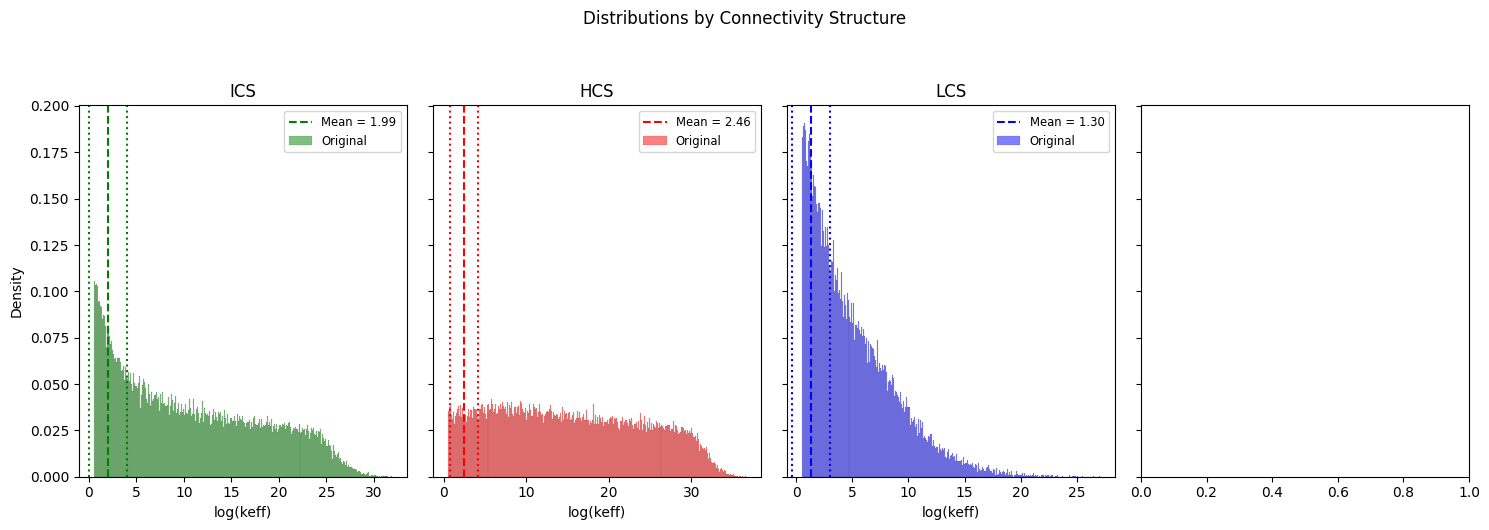

In [27]:
### PDF Analysis ###

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

def filter_and_stats(data, column='keff'):
    '''Filter data within a value of standard deviations'''
    log_data = np.log(data[column])
    mean = log_data.mean()
    std = log_data.std()
    filtered_data = data[(log_data >= mean - 2*std) & (log_data <= mean + 2*std)]
    
    stats = {
        'mean': mean,
        'std': std,
        'skewness': skew(log_data),
        'kurtosis': kurtosis(log_data),
        'n_samples': len(filtered_data)
    }
    return filtered_data, stats

def plot_histogram(data, filtered_data, bins, color, title, ax, show_stats=True):
    '''Plot histogram with original and filtered data'''
    # Plot original data
    sns.histplot(data['keff'], bins=bins, kde=False,
                color=color, alpha=0.50, stat="density", 
                label='Original', ax=ax)
    
    # Plot filtered data
    '''sns.histplot(np.log(filtered_data['keff']), bins=bins, kde=True,
                color=color, alpha=0.75, stat="density", 
                label='Filtered (±2σ)', ax=ax)'''
    
    if show_stats:
        _, stats = filter_and_stats(data)
        ax.axvline(stats['mean'], color=color, linestyle='--', 
                  label=f'Mean = {stats["mean"]:.2f}')
        ax.axvline(stats['mean'] - 2*stats['std'], color=color, linestyle=':')
        ax.axvline(stats['mean'] + 2*stats['std'], color=color, linestyle=':')
    
    ax.set_title(title)
    ax.set_xlabel('log(keff)')
    ax.set_ylabel('Density')
    ax.legend(fontsize='small')
    
    return ax

# Setup parameters
colors = ['green', 'red', 'blue', 'cyan']
bins = 300
lc_values = [6, 8, 10, 12]

# Create filtered datasets
filtered_data_lc = {}
for lc in lc_values:
    subset = data[data['lc'] == lc]
    filtered_subset, stats = filter_and_stats(subset)
    filtered_data_lc[lc] = (filtered_subset, stats)
    print(f"\nStatistics for lc = {lc}:")
    for key, value in stats.items():
        print(f"{key}: {value:.3f}")

# Plot overall distribution
fig, ax = plt.subplots(figsize=(10, 6))
full_filtered_data, full_stats = filter_and_stats(data)
plot_histogram(data, full_filtered_data, bins, 'gray', 
              'Overall Distribution of log(keff)', ax)
plt.tight_layout()
plt.show()

# Plot by lc value
fig, axs = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
for i, lc in enumerate(lc_values):
    filtered_subset, _ = filtered_data_lc[lc]
    plot_histogram(data[data['lc'] == lc], filtered_subset, 
                  bins, colors[i], f'lc = {lc}', axs[i])
plt.suptitle('Distributions by lc value', y=1.05)
plt.tight_layout()
plt.show()

# Plot by connectivity structure
fig, axs = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
con_types = {'ICS': 1, 'HCS': 2, 'LCS': 3}
for i, (label, con_value) in enumerate(con_types.items()):
    subset = data[data['con'] == con_value]
    filtered_subset, _ = filter_and_stats(subset)
    plot_histogram(subset, filtered_subset, bins, colors[i], 
                  label, axs[i])
plt.suptitle('Distributions by Connectivity Structure', y=1.05)
plt.tight_layout()
plt.show()

In [24]:
# Filter out rows where keff is zero or very close to zero
data = pd.read_csv('csv back/ind_output_3D_v4.csv')

# Print original data shape
print(f"Original data shape: {data.shape}")

# Check if 'k3ff' exists, otherwise use 'keff'
target_column = 'k3ff' if 'k3ff' in data.columns else 'keff'

# Define threshold for "close to zero" values
threshold = 0.5  # You can adjust this value as needed

# Count values below threshold before filtering
below_threshold_count = len(data[data[target_column] <= threshold])
print(f"Number of rows with {target_column} <= {threshold}: {below_threshold_count}")
print(f"Percentage of near-zero values: {below_threshold_count/len(data)*100:.2f}%")

# Filter out near-zero values
filtered_data = data[data[target_column] > threshold]
print(f"Filtered data shape: {filtered_data.shape}")
print(f"Removed {len(data) - len(filtered_data)} rows")

# Save filtered data to a new CSV
filtered_data.to_csv('csv back/ind_output_3D_v4_filtered.csv', index=False)
print(f"Filtered data saved to 'csv back/ind_output_3D_v4_filtered.csv'")

# Optional: Display a few rows with near-zero values to verify
if below_threshold_count > 0:
    print("\nSample of rows with near-zero values:")
    print(data[data[target_column] <= threshold].head())

Original data shape: (153600, 22)
Number of rows with keff <= 0.5: 31351
Percentage of near-zero values: 20.41%
Filtered data shape: (122249, 22)
Removed 31351 rows
Filtered data saved to 'csv back/ind_output_3D_v4_filtered.csv'

Sample of rows with near-zero values:
       PPHA    VOLALE  ZNCC     GAMMA  spanning  npz  npy  npx       Plen  \
0  0.100002  0.205302  72.0  0.074034       0.0  0.0  0.0  0.0  12.263649   
1  0.100002  0.237078  70.0  0.089261       0.0  0.0  0.0  0.0  16.628726   
2  0.100002  0.368224  60.0  0.182150       0.0  1.0  0.0  1.0  24.310186   
3  0.100002  0.650353  59.0  0.430460       0.0  0.0  1.0  0.0  23.466047   
5  0.100002  0.146595  65.0  0.069811       0.0  0.0  0.0  0.0  12.175511   

            S  ...          SX        PX     L  con   lc    p       lcG  \
0  364.097222  ...  364.097222  0.000000  64.0  1.0  6.0  0.1  8.430778   
1  374.500000  ...  374.500000  0.000000  64.0  1.0  6.0  0.1  8.996760   
2  436.916667  ...  280.711864  0.368224  64

In [ ]:
### 2D pc = 0.593, para lc = 0, LCS pc poco mayor, ICS y HCS lc menor, a mayor lc menor pc.
### 3D pc = 0.312, para lc = 0, ICS, HCS, LCS pc menor, a mayor lc menor pc.

# prueba 1 3D: L=64, p=[10,50,1000], EC=1, var=1, ref=1, lc=2,3,4, real=1. 3D_test_1 - OK 3.5 h.

# prueba 2 3D: L=64, p=[10,50,1000], EC=2, var=1, ref=1, lc=2,3,4, real=1. 3D_test_2 - OK 3h 5 min.

# prueba 3 3D: L=64, p=[10,50,1000], EC=3, var=1, ref=1, lc=2,3,4, real=1. 3D_test_3 - Ok mas 4 horas

# los resultados no son buenos, sigue el mismo problema.



# prueba 3 3D: L=64, p=[10,50,1000], EC=1, var=1, ref=4, lc=2,3,4, real=1. 3D_test_ref - OK, no finaliza la simulacion en 3 dias solo 2200 real.

### (v3) lc=10 covarianza Gaussiana: se ven mejores resultados, las distribuciones son más uniformes: se realizan simulaciones de lc=6 y 8, el de 6 gneera un doble pico
### en las keff mas alta, para 8 el doble pico es menos pronunciado. Se decide realizar simulaciones de lc=12. En funcion de como salgan se utilizaran 8, 10 y 12.

# Prueba 5: L=64, p=[10,15,100], EC = 1, 2, 3, ref = 1, lc = 8, 10, 12, cov = gauss, seeds = 100, kl = 1, kh = 100
# Prueba 6: L=1024, p=[40,80,100], EC = 1, 2, 3, ref = 1, lc = 128, 160, 192, cov = gauss, seeds = 100, kl = 1, kh = 100

22 ['PPHA' 'VOLALE' 'ZNCC' 'GAMMA' 'spanning' 'npz' 'npy' 'npx' 'Plen' 'S'
 'P' 'PlenX' 'SX' 'PX' 'L' 'con' 'lc' 'p' 'lcG' 'lcNst' 'lcBin' 'keff']
10 ['PPHA' 'VOLALE' 'ZNCC' 'GAMMA' 'spanning' 'Plen' 'S' 'P' 'PlenX' 'lcBin']


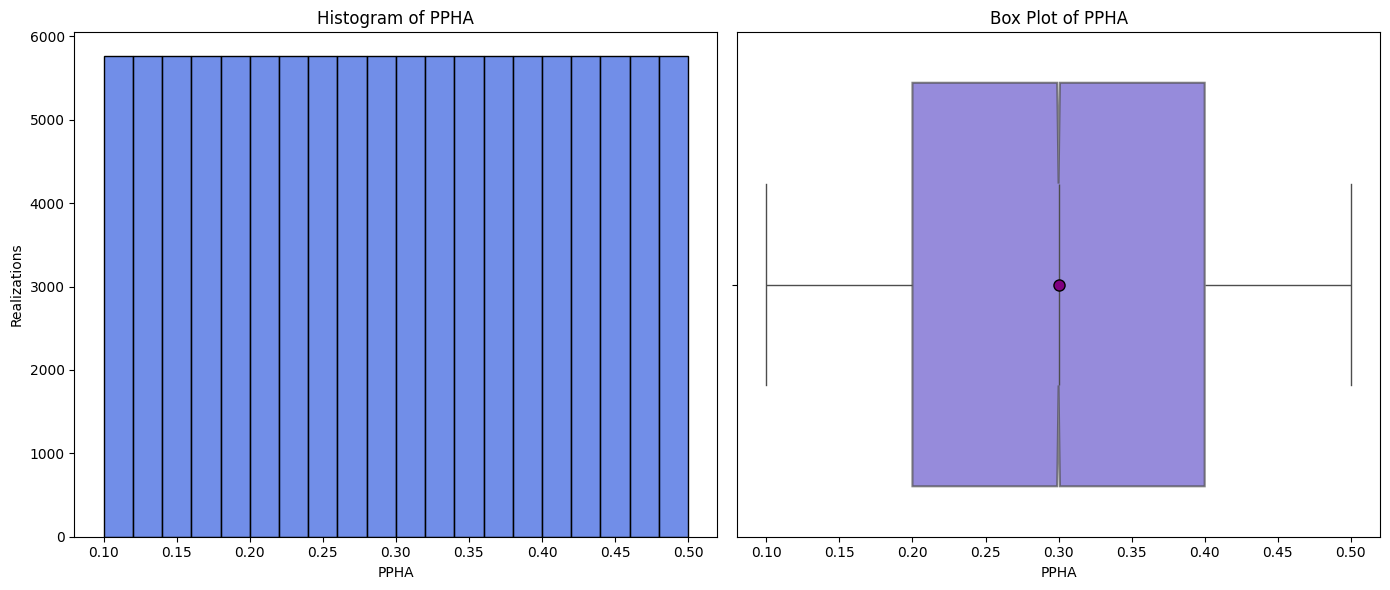

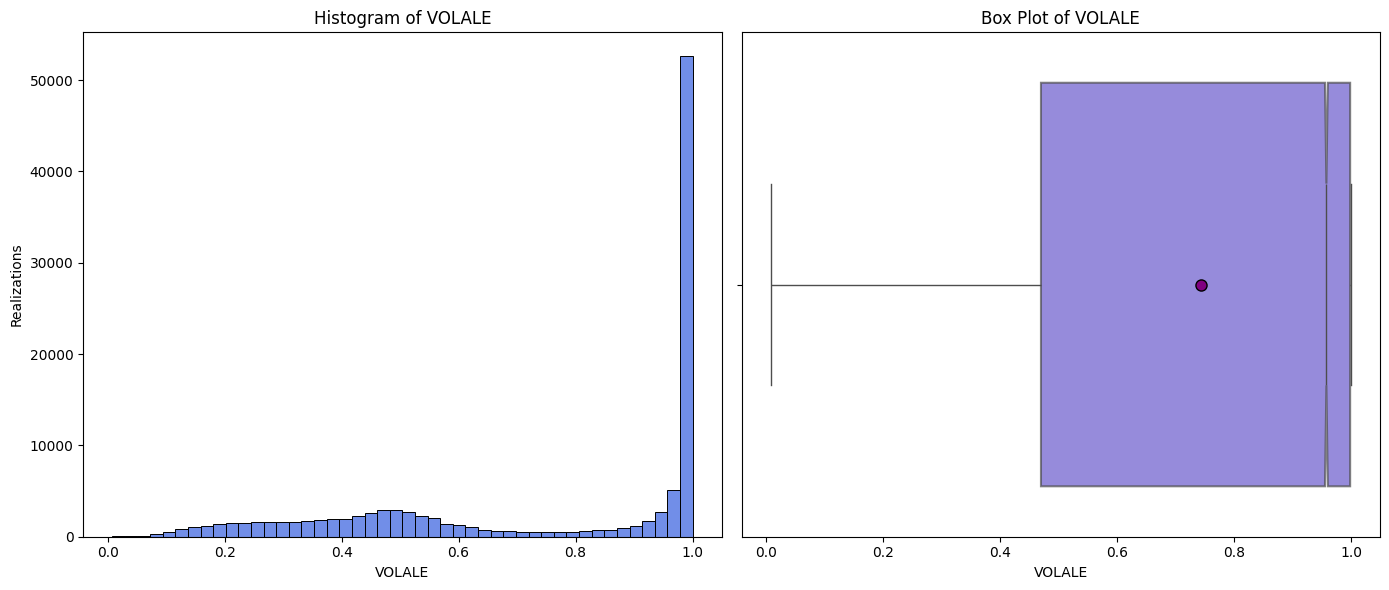

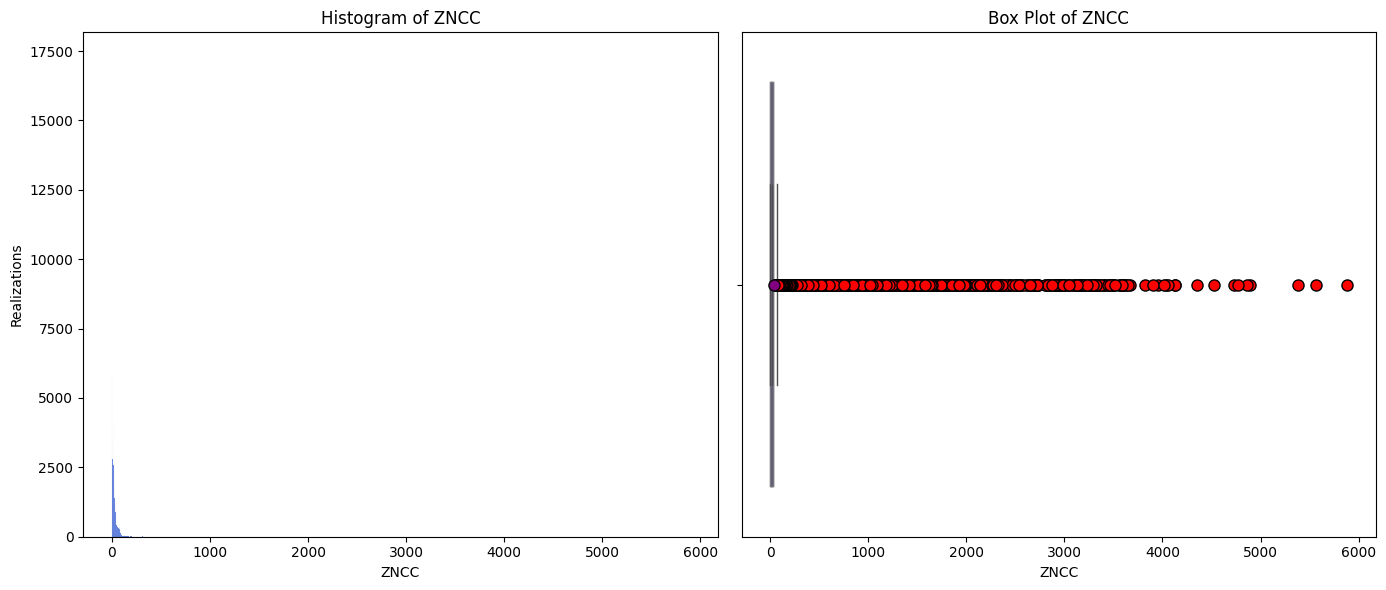

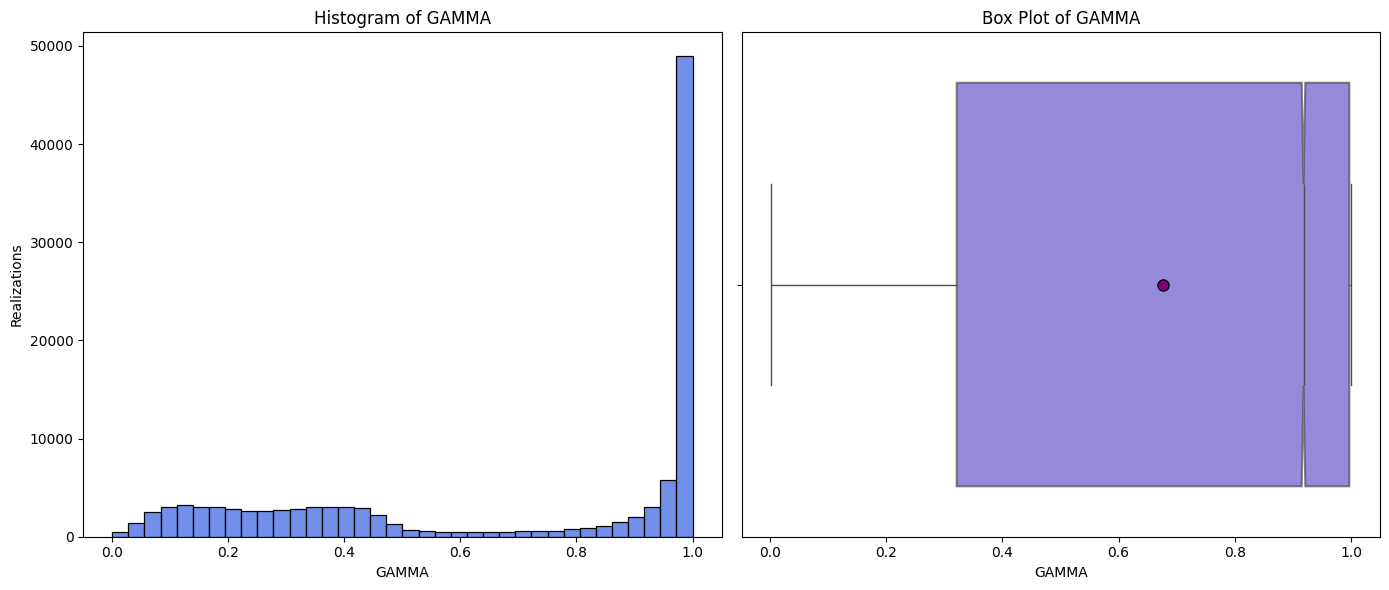

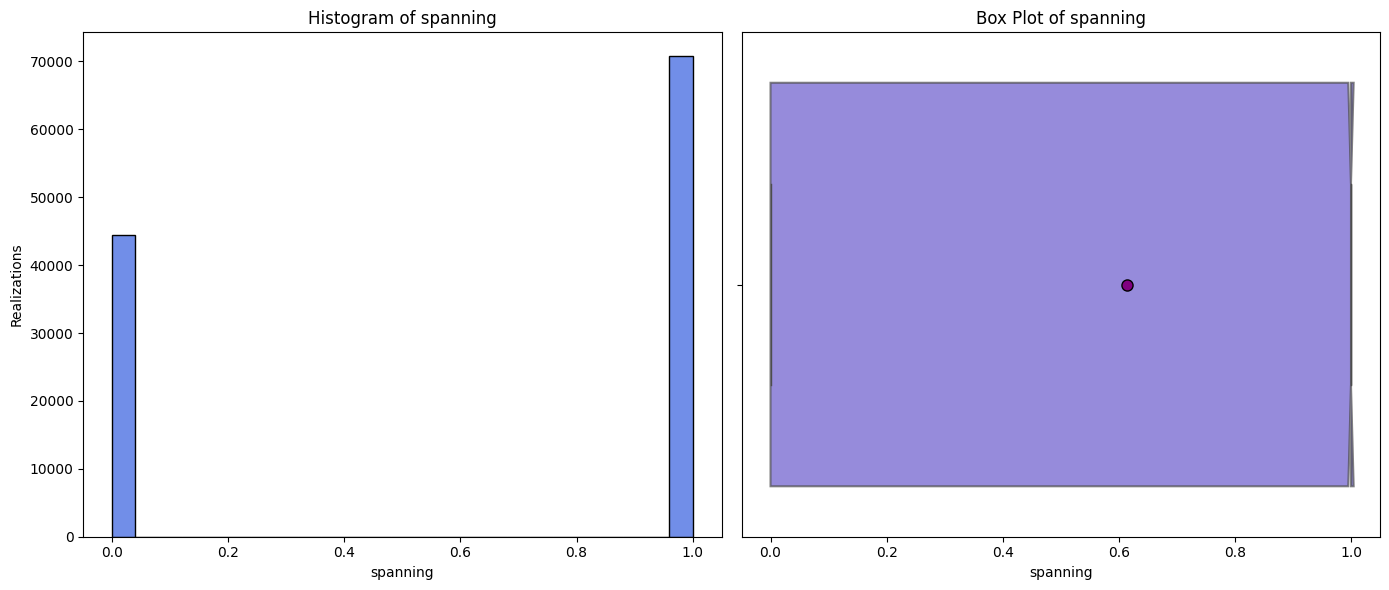

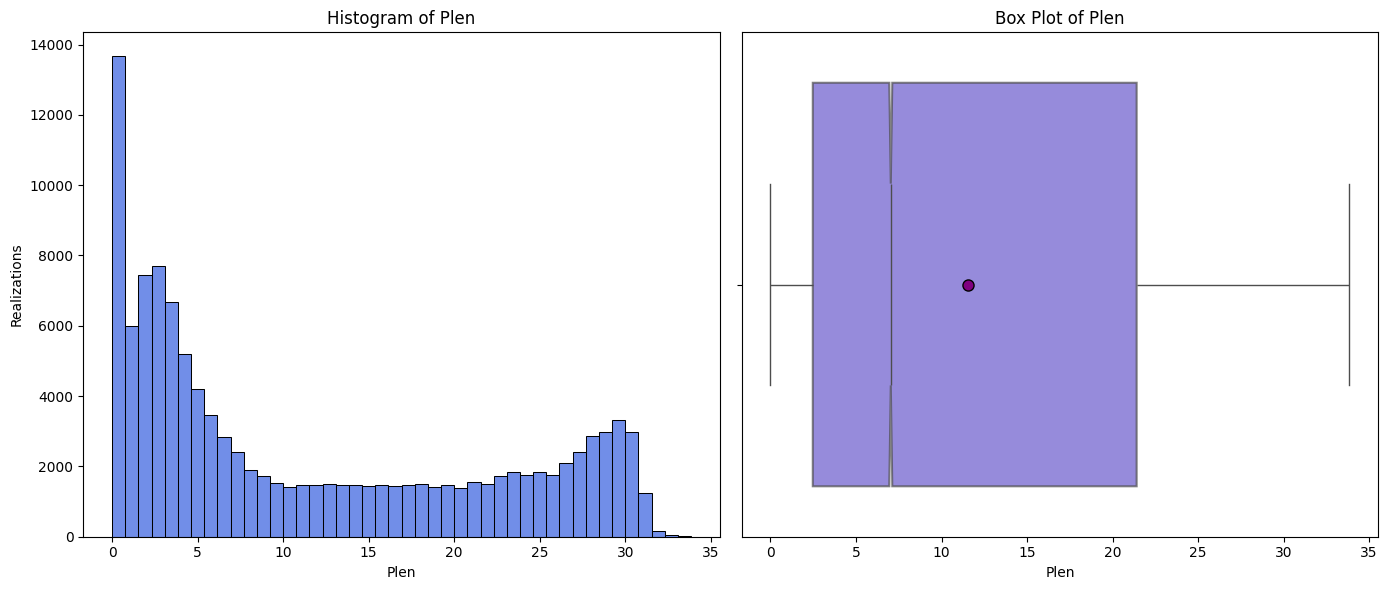

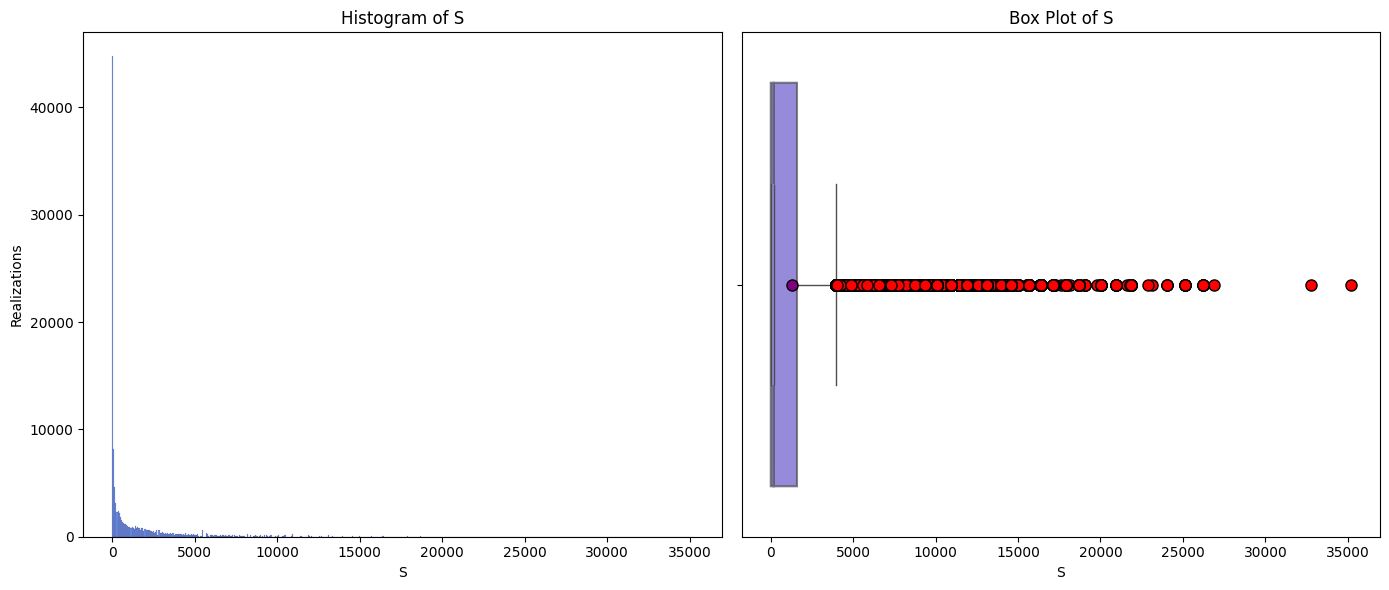

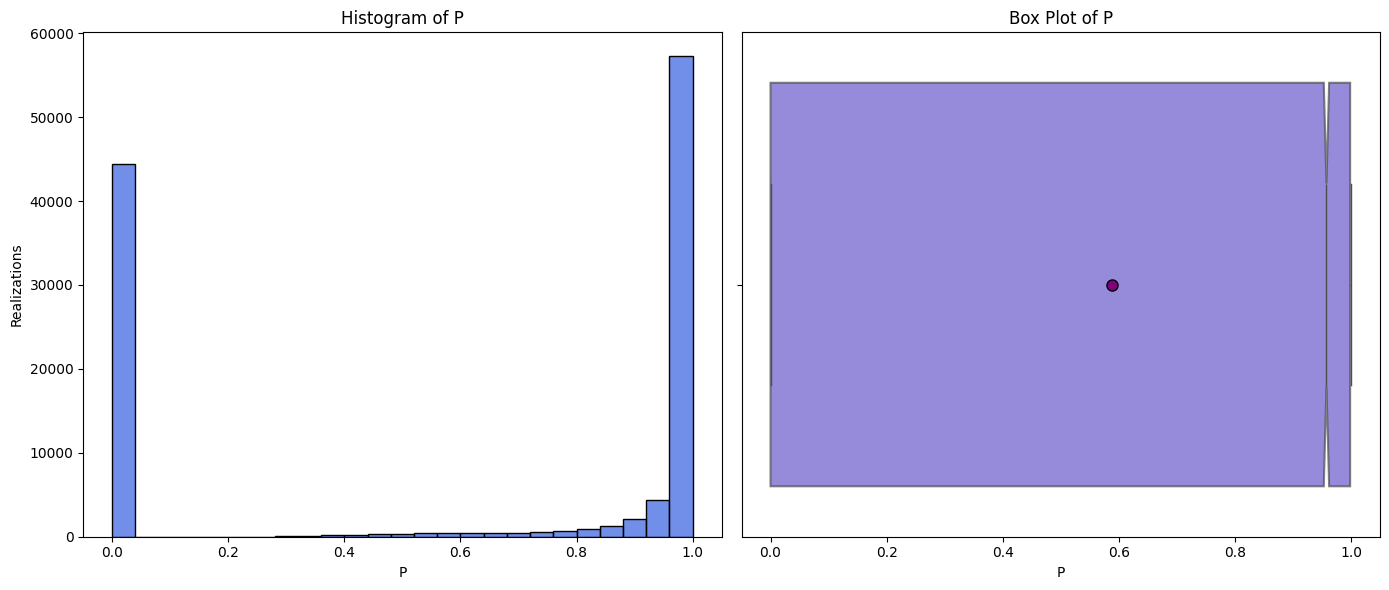

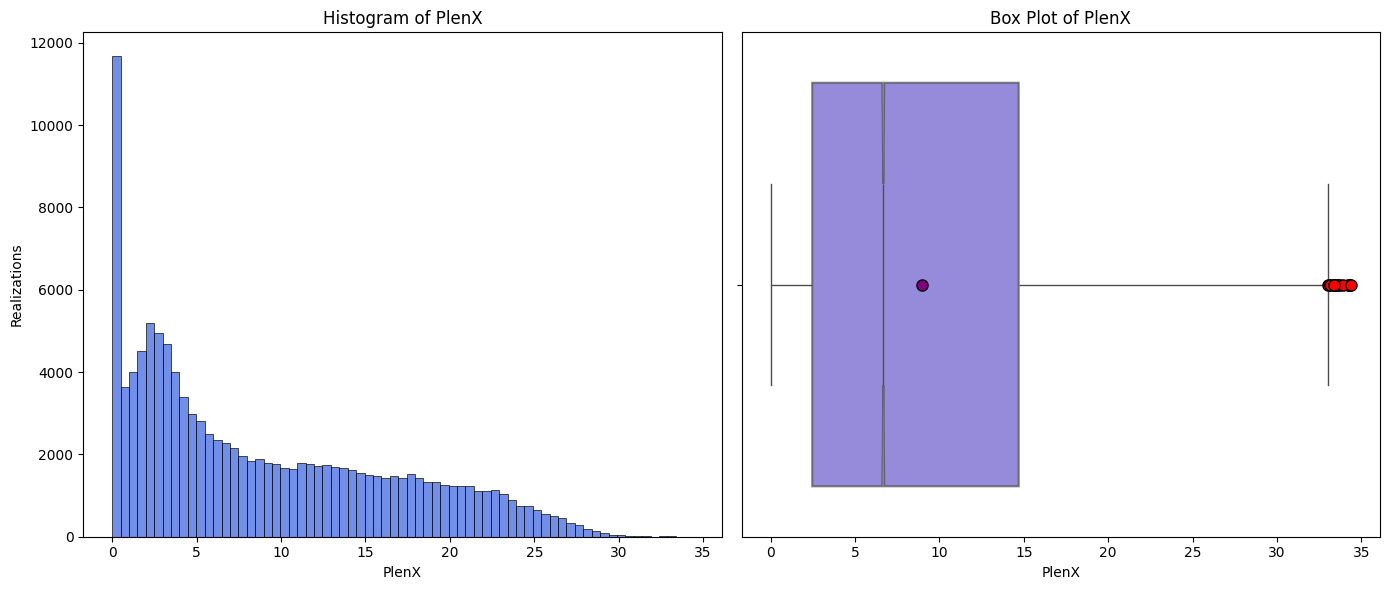

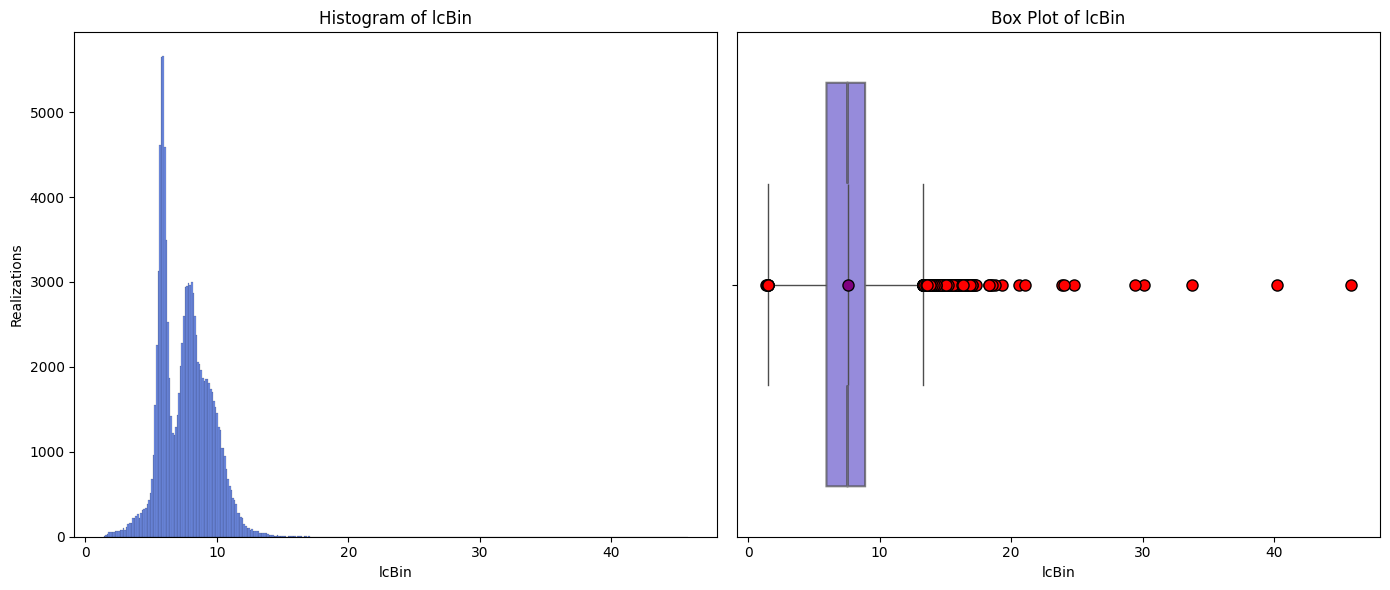

In [49]:
### Histograms and box plots of indicators ###
header = data.columns.to_numpy()
print(len(header), header)
delete = [5, 6, 7, 12, 13, 14, 15, 16, 17, 18, 19, 21]
data_ind = np.delete(header, delete)
print(len(data_ind), data_ind)

for ind in range(len(data_ind)):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    if data_ind[ind] == 'PPHA':
        bins = 20
    else:
        bins = 'auto'

    sns.histplot(data[data_ind[ind]], 
                    bins=bins, kde=False, 
                    color='royalblue', stat="count", 
                    fill=True, 
                    label=data_ind[ind],
                    alpha=0.75, ax=axs[0])
    axs[0].set_ylabel('Realizations')
    axs[0].set_xlabel(data_ind[ind])
    axs[0].set_title(f'Histogram of {data_ind[ind]}')

    sns.boxplot(x=data[data_ind[ind]], color='cyan', ax=axs[1], notch=True, showmeans=True,
                meanprops={'marker':'o', 'markerfacecolor':'purple', 'markeredgecolor':'black', 'markersize':8},
                flierprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'black', 'markersize':8},
                boxprops={'facecolor':'slateblue', 'linewidth':1.5, 'alpha':0.7})
    axs[1].set_xlabel(data_ind[ind])
    axs[1].set_title(f'Box Plot of {data_ind[ind]}')

    plt.tight_layout()
    plt.show()